<table style="width:99%">
<tr>    
<td style="text-align: center">
<h1>Lab 03: Assignment</h1>
<h2>Arkadiusz Paterak</h2>
</td>
</tr>
</table>

# Introduction

The goal of this assignment is to perform a convergence analysis of the upwind scheme.

**The convergence analysis** is a method used to assess how the accuracy of a numerical solution improves as the spatial and temporal resolution is increased (at the cost of increased computational resources).

In [32]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from open_atmos_jupyter_utils import show_plot

# Upwind scheme

In [7]:
class Psi_0:
    def __init__(self, x0=5, a=1, sigma=25):
        self.x0 = x0
        self.a = a
        self.sigma = sigma

    def __call__(self, x):
        return self.a * np.exp(-(x-self.x0)**2 / 2 / self.sigma**2)

class One:
    def __radd__(self, s: slice) -> slice:
        return slice(s.start + 1, s.stop + 1)

    def __rsub__(self, s: slice) -> slice:
        return slice(s.start - 1, s.stop - 1)

def F(psi_L, psi_R, C):
    return 0.5 * (C + np.abs(C)) * psi_L + \
           0.5 * (C - np.abs(C)) * psi_R

In [27]:
def numerical_solution(
    psi_0,
    C,
    x,
    nx,
    nt,
):
    one = One()
    i = slice(1, nx-2)

    psi = psi_0(x)
    for _ in range(nt):
        psi[i] = psi[i] - (
            F(psi[i], psi[i + one], C) - F(psi[i - one], psi[i], C)
        )

    return psi

def analytical_solution(
    psi_0,
    u,
    t_max,
    x
):
    return psi_0(x - u * t_max)

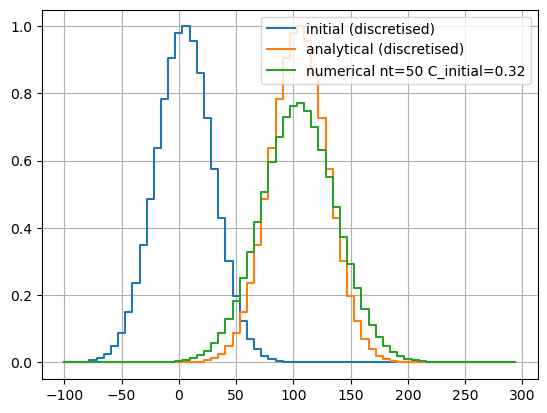

In [ ]:
psi_0 = Psi_0()
nx = 64
x_min, x_max = -100, 300
x, dx_initial = np.linspace(x_min, x_max, nx, endpoint=False, retstep=True)
u = 2
t_max = 50
nt = 50
dt_initial = t_max / nt

C_initial = u * dt_initial / dx_initial

psi = numerical_solution(psi_0=psi_0, C=C_initial, x=x, nx=nx, nt=nt)

plt.step(x, psi_0(x), label='initial (discretised)', where='mid')
plt.step(x, psi_0(x - u * t_max), label='analytical (discretised)', where='mid')
plt.step(x, psi, label=f'numerical {nt=} {C_initial=}', where='mid')
plt.legend()
plt.grid()

In [21]:
dx_initial, dt_initial, C_initial

(6.25, 1.0, 0.32)

# Convergence analysis

## Measure of error

To compare numerical vs. analytical solutions, I use the Root Mean Squared Error (RMSE) as a measure of error:

In [29]:
def rmse(numerical: np.array, analytical: np.array) -> np.array:
    return np.sqrt(np.mean((np.array(numerical) - np.array(analytical))**2))

## Calculations for different $dx$ and $dt$

In [ ]:
results = []

for ratio in [2**p for p in [-4, -3, -2, -1, 0, 1, 2, 3]]:
    dx = dx_initial * ratio
    dt = dt_initial * ratio
    C = u * dt / dx

    x = np.arange(x_min, x_max, dx)
    nx = len(x)

    nt = int(t_max / dt)

    print(f"dx={dx}, dt={dt}, C={C}, nx={nx}, nt={nt}")

    numerical = numerical_solution(psi_0=psi_0, C=C, x=x, nx=nx, nt=nt)
    analytical = analytical_solution(psi_0=psi_0, u=u, t_max=t_max, x=x)
    
    error = rmse(numerical, analytical)

    results.append({
        "dx": dx,
        "dt": dt,
        "nx": nx,
        "nt": nt,
        "C": C,
        "RMSE": error
    })

dx=0.390625, dt=0.0625, C=0.32, nx=1024, nt=800
dx=0.78125, dt=0.125, C=0.32, nx=512, nt=400
dx=1.5625, dt=0.25, C=0.32, nx=256, nt=200
dx=3.125, dt=0.5, C=0.32, nx=128, nt=100
dx=6.25, dt=1.0, C=0.32, nx=64, nt=50
dx=12.5, dt=2.0, C=0.32, nx=32, nt=25
dx=25.0, dt=4.0, C=0.32, nx=16, nt=12
dx=50.0, dt=8.0, C=0.32, nx=8, nt=6


The Courant number remains constant.

## Results

In [79]:
df = pd.DataFrame(results)
df["RMSE"] = df["RMSE"].round(5)

df

,dx,dt,nx,nt,RMSE
0,0.390625,0.0625,1024,800,0.00597
1,0.781250,0.1250,512,400,0.01164
2,1.562500,0.2500,256,200,0.02218
3,3.125000,0.5000,128,100,0.04062
4,6.250000,1.0000,64,50,0.06983
5,12.500000,2.0000,32,25,0.11012
6,25.000000,4.0000,16,12,0.15762
7,50.000000,8.0000,8,6,0.22829


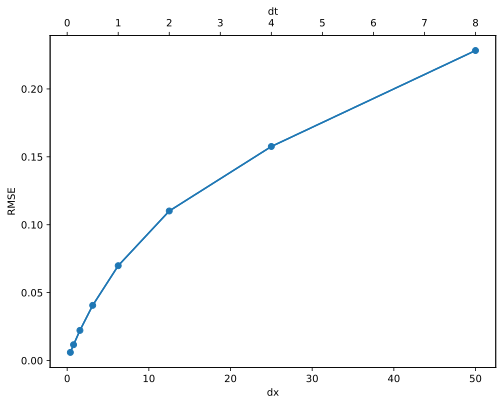

In [86]:
fig, ax1 = plt.subplots(figsize=(8, 6))

ax1.plot(df["dx"], df["RMSE"], label="dx", marker="o")
ax1.set_xlabel("dx")
ax1.set_ylabel("RMSE")
ax1.tick_params(axis="y")

ax2 = ax1.twiny()
ax2.plot(df["dt"], df["RMSE"], label="dt")
ax2.set_xlabel("dt")
ax2.tick_params(axis="x")

show_plot()

# fig, ax1 = plt.subplots(figsize=(8, 6))

# ax1.plot(df["dx"], df["RMSE"], label="dx", marker="o")
# ax1.set_xlabel("dx")
# ax1.set_ylabel("RMSE")
# ax1.tick_params(axis="y")
# ax1.set_yscale("log", base=2)

# ax2 = ax1.twiny()
# ax2.plot(df["dt"], df["RMSE"], label="dt")
# ax2.set_xlabel("dt")
# ax2.tick_params(axis="x")

# show_plot()

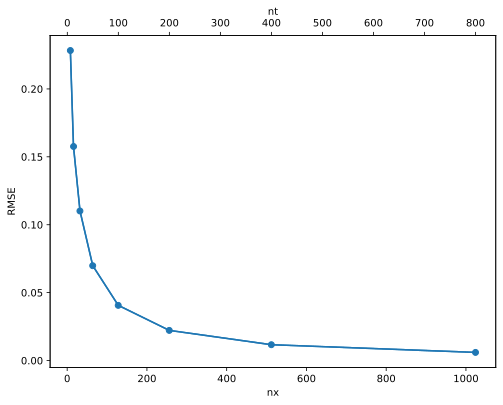

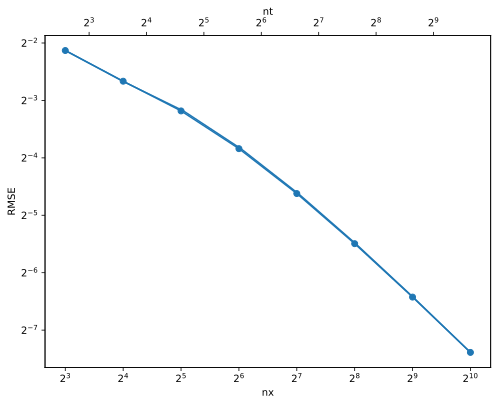

In [92]:
fig, ax1 = plt.subplots(figsize=(8, 6))

ax1.plot(df["nx"], df["RMSE"], label="nx", marker="o")
ax1.set_xlabel("nx")
ax1.set_ylabel("RMSE")
ax1.tick_params(axis="y")

ax2 = ax1.twiny()
ax2.plot(df["nt"], df["RMSE"], label="nt")
ax2.set_xlabel("nt")
ax2.tick_params(axis="x")

show_plot()

fig, ax1 = plt.subplots(figsize=(8, 6))

ax1.plot(df["nx"], df["RMSE"], label="nx", marker="o")
ax1.set_xlabel("nx")
ax1.set_ylabel("RMSE")
ax1.tick_params(axis="y")
ax1.set_xscale("log", base=2)
ax1.set_yscale("log", base=2)

ax2 = ax1.twiny()
ax2.plot(df["nt"], df["RMSE"], label="nt")
ax2.set_xlabel("nt")
ax2.tick_params(axis="x")
ax2.set_xscale("log", base=2)
ax1.set_yscale("log", base=2)

show_plot()

# Conclusions

The converge analysis reveals that increasing both the spatial and temporal resolution by factor of 2, so in total by factor of 4, the accuracy improves only by approximately a factor of 2.